In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yahoo_finance as yf
import pandas_datareader as pdr
from sklearn.cluster import KMeans
from statsmodels.tsa.api import adfuller
from sklearn.preprocessing import StandardScaler

In [391]:
# Modify some settings
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 16
plt.rcParams['figure.dpi'] = 150

pd.options.display.max_rows = 20
pd.options.display.max_columns = 15

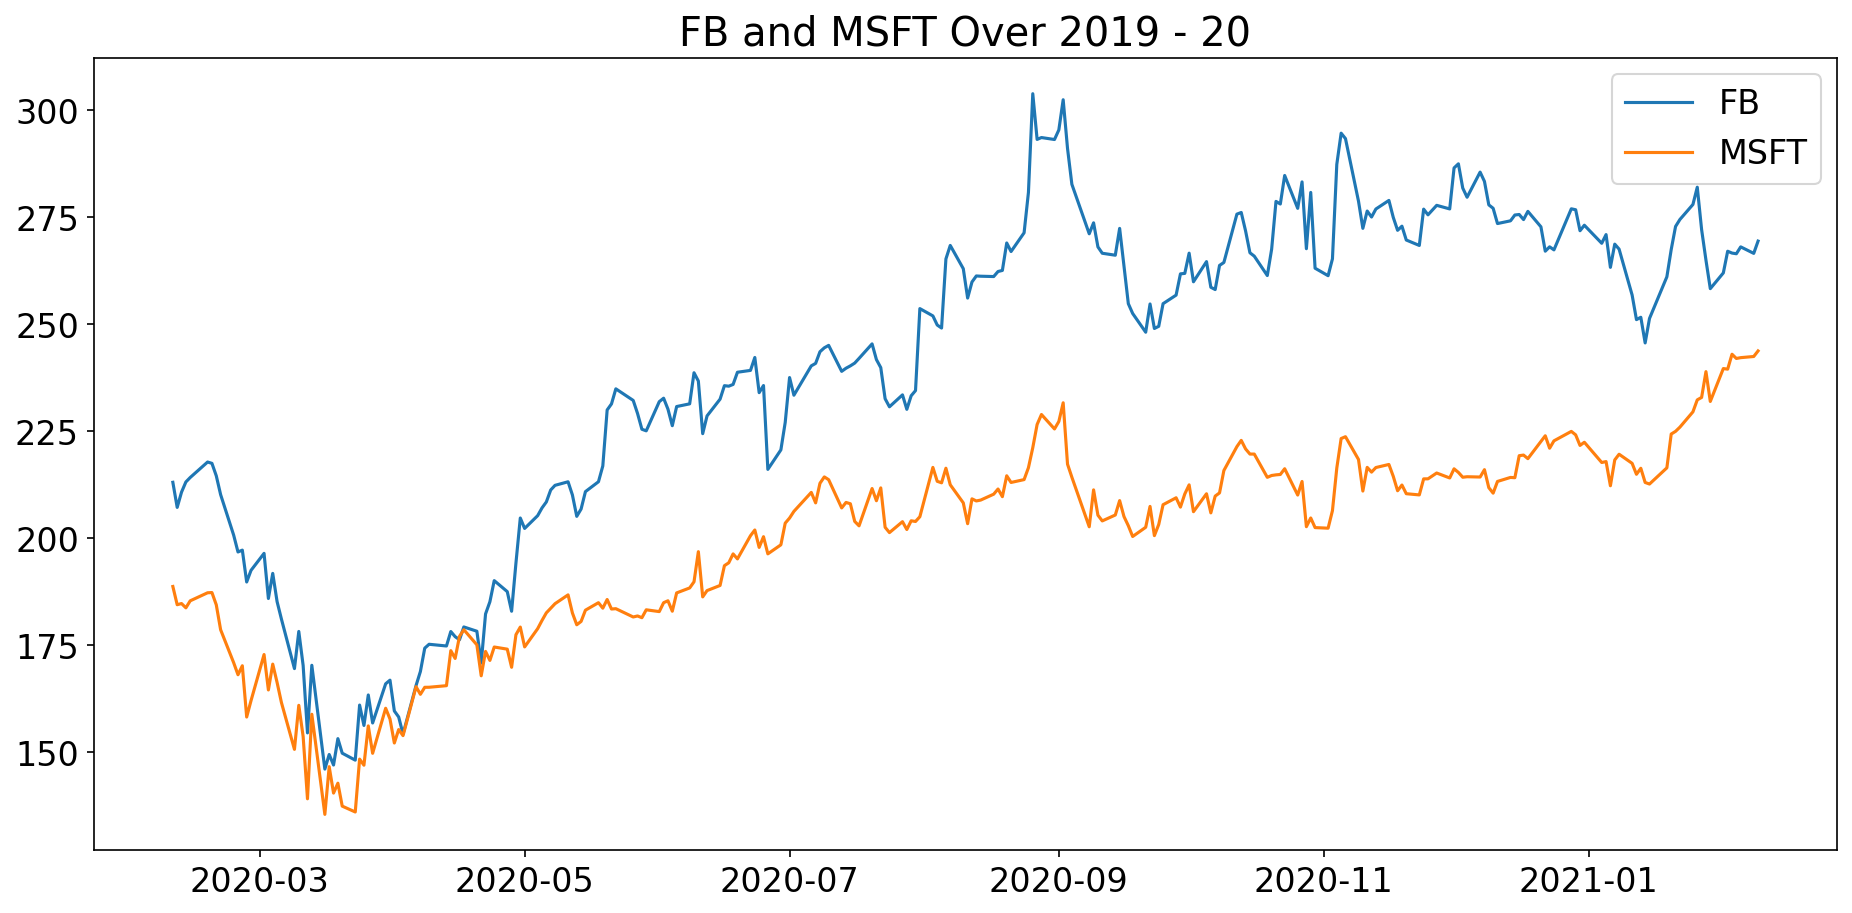

In [392]:
data = pd.read_csv('~/k_means/Data/sp_financials.csv')
data = data.drop(['SEC_Filings', 'Sector', 'Name'], axis=1)
data = data.set_index('Symbol')
data = data.fillna(0)
features = data[['Price', 'Price/Earnings', 'Dividend_Yield', 'Earnings/Share',
       '52_Week_Low', '52_Week_High', 'Market_Cap', 'EBITDA', 'Price/Sales',
       'Price/Book']]

data = StandardScaler().fit_transform(data)

start = '2020-02-09'
end = '2021-02-09'
name_1 = "FB"
name_2 = "MSFT"
s1 = pdr.get_data_yahoo(name_1, start, end)
s2 = pdr.get_data_yahoo(name_2, start, end)

plt.plot(s1['Close'],label=name_1)
plt.plot(s2['Close'],label=name_2)
plt.title(name_1 + ' and ' + name_2 + ' Over 2019 - 20')
plt.legend(loc=0)
plt.show()

In [393]:
class statarb(object):
    '''
    k-means object with ..... atributes 
    methods
    -------
        create_spread:
        check_cointergration:
        generate_signal:
        generate_returns:
        inputs: 
        attributes:
    -----
    '''
    def __init__(self, df1, df2, s1, s2, ma, floor, ceiling, stop_loss_long, stop_loss_short, beta_lookback, start, end, exit_zscore=0):
        self.df1 = df1 # dataframe of stock one
        self.df2 = df2 # dataframe of stock two
        self.s1 = s1 # name of stock one
        self.s2 = s2 # name of stock two        
        self.df = pd.DataFrame(index = df1.index) # new df for data_cleaning method
        self.ma = ma # moving average period
        self.floor = floor # buy threshold for z-score
        self.ceiling = ceiling # sell threshold for z-score
        self.stop_loss_long = stop_loss_long # z-score continues to drop through our floor
        self.stop_loss_short = stop_loss_short # z-score continues to rise through our ceiling 
        self.Close = 'Close Long'
        self.Cover = 'Cover Short'
        self.beta_lookback = beta_lookback # lookback of beta for hedge ratio
        self.start = start # begining of test period
        self.end = end # end of test period
        self.exit_zscore = exit_zscore # z-score
        
    def create_spread(self):
        '''
		parameters
		----------
			self: object: statarb object
		returns
		----------
			self: df: dataframe with chosen stock prices cov, var, beta, hedge ratio and spreads
		'''
        
        # take closing price of chose stocks and add to new dataframe
        self.df[self.s1] = self.df1['Close']
        self.df[self.s2] = self.df2['Close']
        
        # find beta values for pair of stocks. This beta is not the CAPM beta, 
        # its the general beta representing the partial slope coeffiecient in a multivariate
        # (in this case univariate) regression. Given this, it also represents the min variance hedge ratio. 
        # this is a rolling regression.
        ############# need to experiment with different values for lookback window
        self.df['cov'] = self.df[self.s1].rolling(self.beta_lookback).cov(self.df[self.s2])
        self.df['var'] = self.df[self.s2].rolling(self.beta_lookback).var()
        self.df['beta'] = self.df['cov'] / self.df['var']
        
        # set hedge ratio equal to beta of pair
        self.df['Hedge Ratio'] = self.df['beta']
        
        # the spread. For each stock_1 purchased we sell n * stock_2 where n is our hedge ratio
        # If the stocks are cointegrated, it implies the spread equation is stationary, I.E. mean and var are same over time
        # if we choose a hedge ratio such that the spread = 0, if there is cointegration the expected value of
        # the spread will stay = 0. Therefore, any deviation from this will present an opportunity of Stat Arb
        # We check for cointegration in the next method.
        self.df['Spread'] = np.log(self.df[self.s1]) - (self.df['Hedge Ratio']*np.log(self.df[self.s2]))
        self.df['Spread_2'] = np.log(self.df[self.s2]) - (self.df['Hedge Ratio']*np.log(self.df[self.s1]))

        return self.df
    
    def check_cointergration(self):
        '''
		parameters
		----------
			self: object: statarb object
		returns
		----------
			string: stated significance level of the chosen stock cointergration
		''' 
        ####### can imporve this method with matrix vectorization 
        # find coint
        # tells us on a given confidence level weather the par is cointegrated and thus stationary
        adf = adfuller(self.df['Spread'].dropna())
        # print appropriate response
        if adf[0] < adf[4]['1%']:
            print('Spread is Cointegrated at 1% Significance Level')
        elif adf[0] < adf[4]['5%']:
            print('Spread is Cointegrated at 5% Significance Level')
        elif adf[0] < adf[4]['10%']:
            print('Spread is Cointegrated at 10% Significance Level')
        else:
            print('Spread is not Cointegrated')
        return
    
    def generate_signal(self):
        '''
		parameters
		----------
			self: object: statarb object
		returns
		----------
			self: df: dataframe with 1 or 0 values for long, short, and exit signals, and in position markers
		''' 
        # with an assumed distribution of spread ~N(0, 1), its is easy to form threshold levels 
        # these thresholds will act as signal levels 
        # Z = (X - mean) / SD
        # given time series mean and SD will be rolling, using a moving average window
        # create stock z score of the pair spread
        self.df['Z_Score'] = ((self.df['Spread'] - self.df['Spread'].rolling(window = self.ma).mean()) / (self.df['Spread'].rolling(window = self.ma).std()))

        # create prior stock z score        
        self.df['Prior_Z_Score'] = self.df['Z_Score'].shift(1)

        # use z scores to generate buy, sell, exit signals
        # floor and ceiling threshold should be between 1.5 and 2 sigma (change depending on backtest results)
        # LONG SIGNAL = LONG THE SPREAD: BUY STOCK 1, SELL STOCK 2
        # SHORT SIGNAL = SHORT THE SPREAD: SELL STOCK 1, BUY STOCK 2

        self.In_Short = False
        self.In_Long = False
        self.Stopped_Short = False
        self.Stopped_Long = False

        self.df['In_Short'] = 0.0
        self.df['In_Long'] = 0.0

        for i, j in enumerate(self.df.iterrows()):
            current_z = j[1]['Z_Score']
            # are we already in a short trade?
            if self.In_Short == True:
                # heave we been stopped out already?
                # define stop loss criteria
                if current_z >= self.stop_loss_short:
                    # exit trade if stop loss hit
                    # indicate we have been stopped out
                    self.In_Short = False
                    self.Stopped_Short = True
                    self.df.iloc[i]['In_Short'] = 0.0
                # if not stopped, have we hit close criteria?
                elif current_z <= self.exit_zscore:
                    self.In_Short = False
                    self.df.iloc[i]['In_Short'] = 0.0
                # if not stopped and not closed, still in trade
                else:
                    self.df.iloc[i]['In_Short'] = 1.0
            else:
                # why are we not in a short
                # have we been stopped out or did we close position?
                if self.Stopped_Short == True:
                    self.In_Short = False
                    self.df.iloc[i]['In_Short'] = 0.0
                    # if stopped, wait untill we reach exit critera to re-enter teade
                    if current_z <= self.exit_zscore:
                        self.Stopped_Short = False
                # define trade entry criteria
                elif current_z >= self.ceiling:
                    self.In_Short = True
                    self.Stopped_Short = False
                    self.df.iloc[i]['In_Short'] = 1.0       

            # are we already in a long trade?
            if self.In_Long == True:
                # define stop loss criteria
                if current_z <= self.stop_loss_long:
                    # exit trade if stop loss hit
                    # indicate we have been stopped out
                    self.In_Long = False
                    self.Stopped_Long = True
                    self.df.iloc[i]['In_Long'] = 0.0
                elif current_z >= self.exit_zscore:
                    self.In_Long = False
                    self.df.iloc[i]['In_Long'] = 0.0
                else:
                    self.df.iloc[i]['In_Long'] = 1.0
            else:
                # why are we not in a long
                # have we been stopped out or did we close position?
                if self.Stopped_Long == True:
                    self.In_Long = False
                    self.df.iloc[i]['In_Long'] = 0.0
                    if current_z >= self.exit_zscore:
                        self.Stopped_Long = False
                # define trade entry criteria
                elif current_z <= self.floor:
                    self.In_Long = True
                    self.Stopped_Long = False
                    self.df.iloc[i]['In_Long'] = 1.0 
        
        self.df['Floor'] = self.floor
        self.df['Ceiling'] = self.ceiling
        self.df['Long_Stop_Loss'] = self.stop_loss_long
        self.df['Short_Stop_Loss'] = self.stop_loss_short
        
        with plt.style.context(['seaborn-paper']):
            plt.plot(self.df['Z_Score'], label = 'Spread Z-Score')
            plt.plot(self.df['In_Long'], 'g', label = 'In Long Trade')
            plt.plot(self.df['In_Short'], 'r', label = 'In Short Trade')
            plt.plot(self.df['Floor'], 'g--', label = 'Entry Z-Score')
            plt.plot(self.df['Ceiling'], 'g--')
            plt.plot(self.df['Long_Stop_Loss'], 'r--', label = 'Stop Z-Score')
            plt.plot(self.df['Short_Stop_Loss'], 'r--')
            plt.legend(loc = 0)
            plt.tight_layout()
            plt.show()
        

        return self.df
    
    def generate_returns(self, allocation, pair):
        '''
		parameters
		----------
			self: object: statarb object
            allocation: int: desired dollar value for strategy 
            pair: string: names of two chosen stocks
		returns
		----------
			portfolio: df: dataframe with:  Positions,
                                            X,
                                            Y,
                                            Total,
                                            Returns,
                                            Win,
                                            Loss,
                                            Trade_Returns,
                                            Portfolio_Value,
                                            Portfolio_Returns,
                                            Initial_Value,
		''' 
        self.allocation = allocation
        self.pair = pair
        
        # set up portfolio dataframe
        self.portfolio = pd.DataFrame(index = self.df.index)
        # +1 Positions value = Long spread
        # -1 Positions values = Short spread
        self.portfolio['Long_Signal'] = self.df['In_Long']
        self.portfolio['Short_Signal'] = self.df['In_Short']
        self.portfolio['Positions'] = self.df['In_Long'] - self.df['In_Short']
        # Long stock shows negative value = price to represent cash outflow of bought share
        # short stock shows positive value = price to represent cash inflow of borrowed shares
        self.portfolio[self.s1] = -1 * (self.df[self.s1] * self.portfolio['Positions'])
        self.portfolio[self.s2] = (self.df[self.s2] * self.portfolio['Positions'])
        # Total shows current cumulative value of positions
        self.portfolio['Total'] = self.portfolio[self.s1] + self.portfolio[self.s2]
        
        # create percentage returns stream
        # find daily change of total market value of positions
        self.portfolio['Returns'] = self.portfolio['Total'].pct_change()
        self.portfolio['Returns'].fillna(0.0, inplace = True)
        # account for % changes where start = 0 as this would be infinite
        self.portfolio['Returns'].replace([np.inf, -np.inf], 0.0, inplace = True)
        self.portfolio['Returns'].replace(-1.0, 0.0, inplace = True)
        
        # calculate summary statistics
        self.mu = (self.portfolio['Returns'].mean())
        self.sigma = (self.portfolio['Returns'].std())
        self.sharpe = (self.mu - 0.005) / self.sigma
        # where True, yield x, otherwise yield y
        self.portfolio['Win'] = np.where(self.portfolio['Returns'] > 0.0, 1.0, 0.0)
        self.portfolio['Loss'] = np.where(self.portfolio['Returns'] < 0.0, 1.0, 0.0)
        self.wins = self.portfolio['Win'].sum()
        self.losses = self.portfolio['Loss'].sum()
        self.total_trades = self.wins + self.losses
        
        # win loss ratio
        self.wl_ratio = (self.wins / self.losses)
        
        # probability of win and loss
        self.p_win = (self.wins / self.total_trades)
        self.p_loss = (self.losses / self.total_trades)
        
        # avg win / loss return
        self.avg_win_return = (self.portfolio['Returns'] > 0.0).mean()
        self.avg_loss_return = (self.portfolio['Returns'] < 0.0).mean()
        
        # payout ratio
        self.payout_ratio = (self.avg_win_return / self.avg_loss_return)
        
        # getting equity curve
        self.portfolio['Returns'] = (self.portfolio['Returns'] + 1.0).cumprod()
        self.portfolio['Trade_Returns'] = (self.portfolio['Total'].pct_change())
        self.portfolio['Portfolio_Value'] = (self.allocation * self.portfolio['Returns'])
        self.portfolio['Portfolio_Returns'] = self.portfolio['Portfolio_Value'].pct_change()
        self.portfolio['Initial_Value'] = self.allocation
        
        # plot portfolio valuation
        with plt.style.context(['seaborn-paper']):
            plt.plot(self.portfolio['Portfolio_Value'])
            plt.plot(self.portfolio['Initial_Value'])
            plt.title('Statarb Pair %s Strategy Returns %s to %s' %(self.pair, self.start, self.end))
            plt.legend(loc = 0)
            plt.tight_layout()
            plt.show()
            
        return self.portfolio

In [394]:
# create stat arb object
ilmn_vrsn = statarb(s1, s2, name_1, name_2, 14, -2, 2, -2.5, 2.5, 28, start, end)

In [395]:
# find spreads
ilmn_vrsn.create_spread()

,FB,MSFT,cov,var,beta,Hedge Ratio,Spread,Spread_2
Date,,,,,,,,
2020-02-10,213.059998,188.699997,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-11,207.190002,184.440002,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-12,210.759995,184.710007,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-13,213.139999,183.710007,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-14,214.179993,185.350006,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-02-03,266.649994,243.000000,31.059809,77.481806,0.400866,0.400866,3.383956,3.253850
2021-02-04,266.489990,242.009995,31.406867,88.324137,0.355586,0.355586,3.633530,3.502909
2021-02-05,268.100006,242.199997,32.639137,98.713678,0.330645,0.330645,3.776200,3.641011


In [396]:
# check cointergration level
ilmn_vrsn.check_cointergration()

Spread is Cointegrated at 5% Significance Level


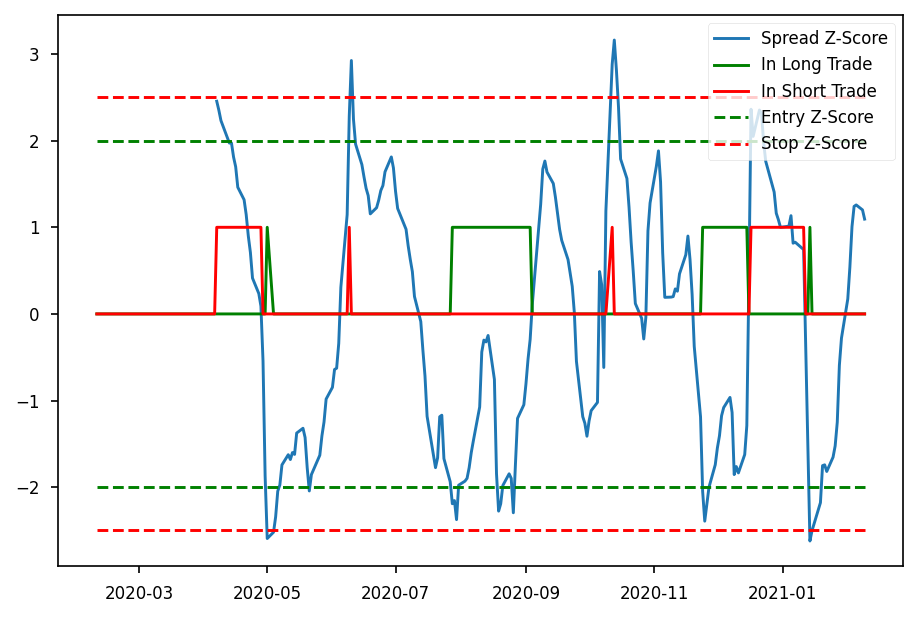

,FB,MSFT,cov,var,beta,Hedge Ratio,Spread,...,Prior_Z_Score,In_Short,In_Long,Floor,Ceiling,Long_Stop_Loss,Short_Stop_Loss
Date,,,,,,,,,,,,,,,
2020-02-10,213.059998,188.699997,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,-2,2,-2.5,2.5
2020-02-11,207.190002,184.440002,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,-2,2,-2.5,2.5
2020-02-12,210.759995,184.710007,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,-2,2,-2.5,2.5
2020-02-13,213.139999,183.710007,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,-2,2,-2.5,2.5
2020-02-14,214.179993,185.350006,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,-2,2,-2.5,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-03,266.649994,243.000000,31.059809,77.481806,0.400866,0.400866,3.383956,...,0.543249,0.0,0.0,-2,2,-2.5,2.5
2021-02-04,266.489990,242.009995,31.406867,88.324137,0.355586,0.355586,3.633530,...,1.007229,0.0,0.0,-2,2,-2.5,2.5
2021-02-05,268.100006,242.199997,32.639137,98.713678,0.330645,0.330645,3.776200,...,1.241295,0.0,0.0,-2,2,-2.5,2.5


In [397]:
# generate trade signals 
ilmn_vrsn.generate_signal()

No handles with labels found to put in legend.


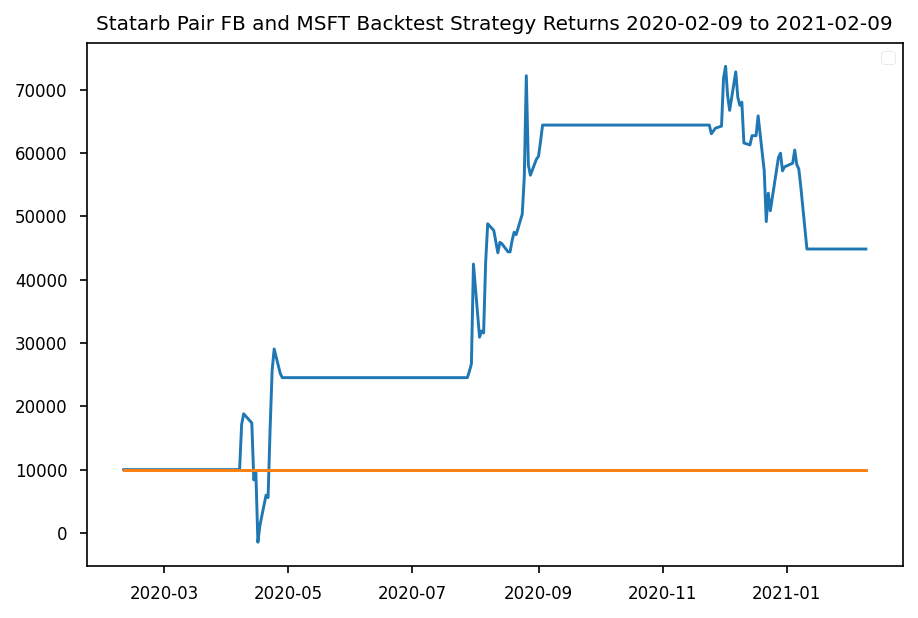

,Long_Signal,Short_Signal,Positions,FB,MSFT,Total,Returns,Win,Loss,Trade_Returns,Portfolio_Value,Portfolio_Returns,Initial_Value
Date,,,,,,,,,,,,,
2020-02-10,0.0,0.0,0.0,-0.0,0.0,0.0,1.000000,0.0,0.0,NaN,10000.000000,NaN,10000
2020-02-11,0.0,0.0,0.0,-0.0,0.0,0.0,1.000000,0.0,0.0,NaN,10000.000000,0.0,10000
2020-02-12,0.0,0.0,0.0,-0.0,0.0,0.0,1.000000,0.0,0.0,NaN,10000.000000,0.0,10000
2020-02-13,0.0,0.0,0.0,-0.0,0.0,0.0,1.000000,0.0,0.0,NaN,10000.000000,0.0,10000
2020-02-14,0.0,0.0,0.0,-0.0,0.0,0.0,1.000000,0.0,0.0,NaN,10000.000000,0.0,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-03,0.0,0.0,0.0,-0.0,0.0,0.0,4.486031,0.0,0.0,NaN,44860.314986,0.0,10000
2021-02-04,0.0,0.0,0.0,-0.0,0.0,0.0,4.486031,0.0,0.0,NaN,44860.314986,0.0,10000
2021-02-05,0.0,0.0,0.0,-0.0,0.0,0.0,4.486031,0.0,0.0,NaN,44860.314986,0.0,10000


In [398]:
# show portfolio value over trade period
pair = name_1 + " and " + name_2 + " Backtest"
ilmn_vrsn.generate_returns(10000, pair)

In [399]:
ilmn_vrsn.sharpe

0.04299599972054409

In [400]:
ilmn_vrsn.wl_ratio

1.121212121212121

In [401]:
ilmn_vrsn.p_win

0.5285714285714286

In [402]:
ilmn_vrsn.p_loss

0.4714285714285714

In [403]:
ilmn_vrsn.avg_win_return

0.14624505928853754

In [404]:
ilmn_vrsn.avg_loss_return

0.13043478260869565

In [405]:
ilmn_vrsn.payout_ratio

1.121212121212121